In [25]:
%matplotlib widget
import matplotlib.pyplot as plt
import cv2 as cv
from IPython.display import display, clear_output

"""
import necessary modules
"""
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
from tool import util

"""
parameters
"""
#robot_ip_address = "169.254.60.223" # robot ip address
robot_ip_address = "192.168.254.87"

output_config = {
    "pick_init":[0, 0, 0],
    "decap_init": [1, 0, 0],
    "gripper": [0, 1, 0],
    "decap": [1, 1, 0],
    "pick": [0, 1, 1],
    "barcode": [0, 1, 1],
    "decap_place": [0, 1, 0],
}
tcp = {
    "5ml_cap": [0, 0, 50, 0, 0, 90], #3
    "15ml_cap":[0, 0, 40, 0, 0, 90],
    "50ml_cap": [0, 0, 50, 0, 0, 90],
}

camera_prm = {
    "pick": {
        "sn": "130322273348"
    },
    "level": {
        "sn": "130322272326"
    }
}

decap_round = {
    "5ml_cap": 6,
    "15ml_cap": 7,
    "50ml_cap": 4,
}

"""decap_round = {
    "5ml_cap": 2,
    "15ml_cap": 3,
    "50ml_cap": 2,
}"""

imaging_joint = [90.175781, 79.958496, -108.325195, 0.219727, -67.456055, 0]
middle_joint = imaging_joint

# decap
decap_position = {
    "5ml_cap": [167.466961, 275.304174+0.5, 140, 127, -127, 0],
    "15ml_cap": [141.401519, 275.304174+0.5, 140, 127, -127, 0],
    "50ml_cap": [167.466961, 275.304174+0.5, 140, 127, -127, 0],
}

decap_position_down = {
    "5ml_cap": [0, 0, -25+6, 0, 0, 0],
    "15ml_cap": [0, 0, -25+6, 0, 0, 0],
    "50ml_cap": [0, 0, -25+6, 0, 0, 0],
}

tube_position_down = {
    "5ml_cap": [0, 0, -23+4, 0, 0, 0],
    "15ml_cap": [0, 0, -23+4, 0, 0, 0],
    "50ml_cap": [0, 0, -25+2, 0, 0, 0],
}

cap_drop_pose = [228, 107, 140, 180, 0, 0]
#cap_drop_pose = [228, 107, 140, 127, -127, 0]

#barcode_pose = [353.225201+5, 274.642718-25, 140-5, 127, -127, 0]
barcode_pose = {
    "5ml_cap": [353.225201+5, 274.642718-25, 140-5, 127, -127, 0],
    "15ml_cap": [353.225201+5+10, 274.642718-25, 140-5, 127, -127, 0],
    #"50ml_cap": [353.225201+5+5, 274.642718-25, 140-5, 79.93813672007843, 160.84633090092228, 1.5245427480262337],
    "50ml_cap": [353.225201+5+5, 274.642718-25, 140-5, 127, -127, 0],
}


speed_pick = 0.5 # here set the speed of the robot
above = [40, 140, 140, 140]
motion = "lmove"
sim=0
freedom = {"num" : 10, "range" : [0.1,0.1,0.1], "early_exit": False }

# detection parameters
detection_prm = {
    "tube":{
        "camera_mount":{
            "type": "dorna_ta_j4",
            "ej": [0 ,0, 0, 0, 0, 0, 0, 0],
            "T": [46.5174596+1+1, 32.0776662-3+1-0, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
        },
        'detection': {'cmd': 'od', 'path': 'tube.pkl', 'conf': 0.2, 'cls': []}, 
        'limit': {'area': [0, 100000], 'aspect_ratio': [0.1, 1.0], 'xyz': [[-140, 110], [200, 420], [0, 140]], 'inv': 0}, 
        'output': {'max_det': 100, 'shuffle': True, 'save_img': False, 'save_img_roi': False}
        },
    "level":{
        'detection': {'cmd': 'od', 'path': 'level.pkl', 'conf': 0.5, 'cls': []}, 
        'roi': {'corners': [[212, 0], [635, 0], [635, 479], [212, 479]], 'inv': False, 'crop': True}, 
        'output': {'max_det': 100, 'shuffle': True, 'save_img': True, 'save_img_roi': False}
        },
    "barcode":{
        'detection': {'cmd': 'cls', 'path': 'barcode.pkl', 'conf': 0.5, 'cls': []}, 
        'roi': {'corners': [[254, 144], [593, 144], [593, 335], [254, 335]], 'inv': False, 'crop': True}, 
        'output': {'max_det': 100, 'shuffle': True, 'save_img': False, 'save_img_roi': False}
        },
}


"""detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0, 0, 0, 0, 0, 0, 0],
        "T": [46.5174596+1+1, 32.0776662-3+1-0, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
    },
    'detection': {'cmd': 'od', 'path': 'tube.pkl', 'conf': 0.5, 'cls': []}, 
    'limit': {'area': [0, 100000], 'aspect_ratio': [0.1, 1.0], 'xyz': [[-140, 110], [200, 420], [0, 140]], 'inv': 0}, 
    'output': {'max_det': 100, 'shuffle': True, 'save_img': True, 'save_img_roi': True}
    }
"""
# best_pick
bb_radius = 100
rvec_base = [180, 0, 0]
finger_location = [0, 180]
padding = 10 # pixel 10
gripper_opening = 55 #mm 50
gripper_thickness = 12
xyz_min = 40
aspect_ratio = 0.9
num_sample = 32
search_rotation = [-95, 95]
xyz_error_thr = 10 # mm

# fine tuned
fine_tuned = True

In [5]:
robot = Dorna()
#{"cmd":"lmove","rel":0,"x":141.604314,"y":275.951218,"z":180.010783,"a":179.249096,"b":-0.181106,"c":-0.606103}
pose = [179.249096, -0.181106, -0.606103]
result = robot.kinematic.rotate_rvec(rvec=pose, axis=[0,0,1], angle=-180, local=True)
print(result)

{"cmd":"lmove","rel":0,"x":167.674126,"y":276.035906,"z":189.993441,"a":179.382475,"b":-0.444518,"c":0.317128}
{"cmd":"lmove","rel":0,"x":167.674126,"y":276.035906,"z":189.993441,"a":0.445539,"b":179.794263,"c":-0.967607}

x = [0.445539-179.382475, 179.794263+0.444518, -0.967607-0.317128]
print(x)

[-0.18146922807768953, -179.60859985162165, 1.1752270141947836]
[-178.936936, 180.238781, -1.284735]


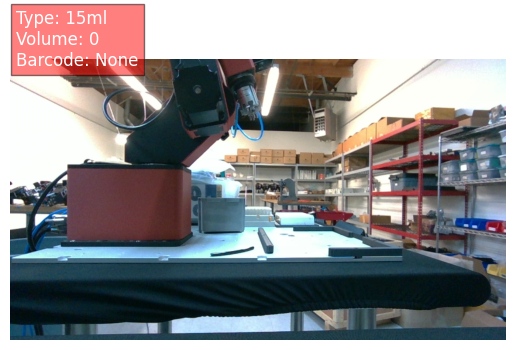

In [26]:
# init plot
fig, ax = plt.subplots()

"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera_pick = Camera() # initialize camera
camera_pick.connect(serial_number=camera_prm["pick"]["sn"]) # connect to camera

camera_level = Camera() # initialize camera
camera_level.connect(serial_number=camera_prm["level"]["sn"]) # connect to camera


detection_tube = Detection(camera=camera_pick, robot=robot, **detection_prm["tube"]) # initialize the object detection
detection_level = Detection(camera=camera_level, robot=robot, **detection_prm["level"]) # initialize the object detection
detection_barcode = Detection(camera=camera_level, robot=robot, **detection_prm["barcode"]) # initialize the object detection


"""
init robot
"""
robot.set_output(output_config["pick_init"][0], output_config["pick_init"][1]) # set output
robot.set_output(output_config["decap_init"][0], output_config["decap_init"][1]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving

"""
run the object detection and pick and place
"""
for i in range(1):  # range is set to 5 because we have 5 chips
    #set safe initial position
    robot.go(joint=imaging_joint, speed=speed_pick, sim=sim)
    
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.1)

    # run the object detection
    tube_result = detection_tube.run()
    img_1 = detection_tube.img.copy()
    
    # assign tcp to each pose
    for r in tube_result:
        if r["cls"] in tcp:
            r["tcp"] = tcp[r["cls"]]
    
    # best pick
    best_pick_result = util.best_pick(tube_result,
                                    rvec_base, 
                                    detection_tube.camera_data["joint"], 
                                    robot, detection_tube.frame_mat_inv, 
                                    camera_pick.camera_matrix(detection_tube.camera_data["depth_int"]), camera_pick.dist_coeffs(detection_tube.camera_data["depth_int"]), 
                                    padding, gripper_opening, freedom, gripper_thickness, xyz_min, aspect_ratio, num_sample,
                                    search_rotation, finger_location, bb_radius)

    if best_pick_result is None:
        continue

    # assign
    pick_pose, label, pxl_list, o, pose_valid_list, pose_not_valid_list, detection_result = best_pick_result

    if fine_tuned:
        # go second detection
        robot.kinematic.set_tcp_xyzabc(tcp[label])
        second_img_pose = list(pick_pose)
        second_img_pose[2] += above[1]/3
        second_img_pose[1] += -20
        second_img_joint = robot.kinematic.inv(second_img_pose, detection_tube.camera_data["joint"], False,freedom=freedom)[0]
        second_img_joint[5] = 0
        robot.go(joint=second_img_joint, tcp=tcp[label], speed=speed_pick, sim=sim, motion=motion)
        
        # run the object detection
        time.sleep(0.1)
        tube_result = detection_tube.run()

        # fine tuned
        for r in tube_result:
            if np.linalg.norm(np.array(r["xyz"]) - np.array(pick_pose[0:3])) < xyz_error_thr:
                #pick_pose[0:3] = r["xyz"]
                continue
        
        
    # this executes the pick-and-place operation
    retval = robot.pick_n_place(
        pick_pose=pick_pose, # pick position we got from detection
        place_pose=barcode_pose[label], # place poistion which we got from the class
        tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["pick"], # output in order (pin, off state, on state)
        above=above,
        motion=motion,
        sim=sim,
        )

    # barcode
    volume, corners, barcode = util.barcode_read(robot, detection_level, detection_barcode, label)

    """
    plot
    """
    disp_img = util.tube_img_barcode(detection_level.camera_data["color_img"].copy(), corners)
    ax.clear()  # Clear the previous image
    ax.imshow(cv.cvtColor(disp_img, cv.COLOR_BGR2RGB))  # Display the new image
    ax.axis('off')  # Optional: Hide axis ticks
    ax.text(
        10, 10,  # Coordinates for the text
        "Type: "+label.split('_')[0]+"\nVolume: "+str(round(volume, 2))+"\nBarcode: "+str(barcode),  # Multi-line text
        color="white",
        fontsize=12,
        bbox=dict(facecolor='red', alpha=0.5)
    )
    # Display the image and update
    clear_output(wait=True)  # Clear the previous output in the Jupyter cell
    display(fig)  # Display the updated figure

    # go to decap
    retval = robot.pick_n_place(
        place_pose=decap_position[label], # place poistion which we got from the class
        tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["decap_init"], # output in order (pin, off state, on state)
        above=above[1],
        motion=motion,
        sim=sim,
        )
    
    
    # decap
    util.decap(robot, label, output_config["gripper"], output_config["decap"], decap_position, decap_position_down, tcp, decap_round[label])
    

    # drop_cap
    retval = robot.pick_n_place(
        place_pose=cap_drop_pose, # place poistion which we got from the class
        tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["gripper"], # output in order (pin, off state, on state)
        above=above[1]/2,
        motion=motion,
        sim=sim,
        )

    # pick_vial and drop
    retval = robot.pick_n_place(
        pick_pose = np.array(decap_position[label])+np.array(tube_position_down[label]),
        place_pose= np.array(pick_pose)+np.array([0, 0, 5, 0 , 0, 0]), # place poistion which we got from the class
        end_joint=imaging_joint,
        tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["gripper"], # output in order (pin, off state, on state)
        above=above[0:3]+[above[0]],
        motion=motion,
        pick_cmd_list=[{"cmd":"output", "out"+str(output_config["decap"][0]): output_config["decap"][2], "queue":0},
                        {"cmd": "sleep", "time": 0.5}],
        sim=sim,
        freedom = freedom
    )

robot.close() # close robot
camera_pick.close() # close camera
camera_level.close() # close camera
detection_tube.close() # close object detection
detection_level.close() # close object detection
detection_barcode.close() # close object detection
plt.close(fig) # close plot


In [5]:
str(None)

'None'

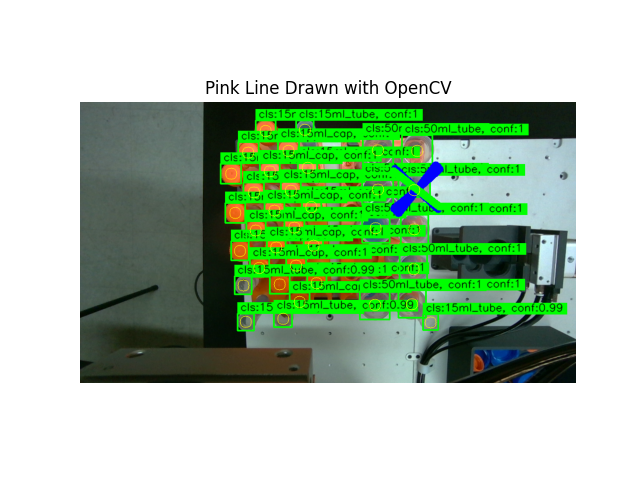

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import cv2 as cv
# draw start end
img = img_1.copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = gripper_thickness


# good
for p in pose_valid_list:
    for pxl in p[1]:
        cv.line(img, pxl, p[2], (255, 0, 0), thickness)

"""
# bad
for p in pose_not_valid_list:
    for pxl in p[1]:
        cv.line(img, pxl, p[2], (0, 0, 255), thickness)
"""
# best
for pxl in pxl_list:
    cv.line(img, pxl, o, (0, 255, 0), thickness)

# pick
for r in tube_result:
    cv.circle(img, r["center"], 10, (0, 255, 255), 1)

# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()